In [2]:
import pandas as pd 
import numpy as np
import os
os.chdir('/home/spankaew/Git/astrologics')

In [3]:
path_to_file = '/home/spankaew/Git/astrologics/models/dev/'
model_list = os.listdir(path_to_file)

In [13]:
def gini(array):
    """Calculate Gini coefficient of array of values."""
    array = np.sort(np.array(array))
    index = np.arange(1, array.shape[0] + 1)
    n = array.shape[0]
    return (2 * np.sum(index * array) / (n * np.sum(array))) - (n + 1) / n

In [40]:
# For loop to identify attractor groups for each network
attractor_counts = pd.DataFrame(columns=['project_name', 'num_model', 'num_attractors', 'gini_score'])
for project_name in model_list:
    attractor_df = pd.read_csv('/home/spankaew/Git/astrologics/models/attractor_group/' + project_name + '_attractors.csv', index_col=0)
    concatenated_columns = attractor_df.apply(lambda col: ''.join(col.astype(str)), axis=0)
    vis_bar = pd.DataFrame(concatenated_columns.value_counts().sort_values(ascending=False))
    vis_bar['attractor_group'] = [i for i in range(len(vis_bar))]
    vis_bar = vis_bar.reset_index()

    # Create dictionary for mapping
    model_path = path_to_file + project_name +'/'
    attractor_dict = dict(zip(vis_bar['index'], vis_bar['attractor_group']))
    concatenated_columns = pd.DataFrame(concatenated_columns.map(attractor_dict), columns=['attractor_group'])
    concatenated_columns.to_csv('/home/spankaew/Git/astrologics/models/attractor_group/' + project_name + '_attractor_group.csv', index = True)

    # Calculate cluster distribution score
    gini_score = gini(vis_bar['count'].values)

    # Calculate the number of attractors
    num_attractors = len(vis_bar)
    num_model = len(concatenated_columns)
    attractor_counts = pd.concat([attractor_counts, pd.DataFrame({'project_name': [project_name], 
                                                                  'num_model': [num_model],
                                                                  'num_attractors': [num_attractors],
                                                                  'gini_score': [gini_score]})], 
                                                                  ignore_index=True)

# Save the dataframe to CSV if needed
attractor_counts.to_csv('/home/spankaew/Git/astrologics/models/attractor_group/attractor_counts.csv', index=True)

/tmp/ipykernel_34392/1318938286.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  attractor_counts = pd.concat([attractor_counts, pd.DataFrame({'project_name': [project_name],


In [1]:
import pandas as pd 
import numpy as np
import os

import sys
sys.path.append('/home/spankaew/Git/astrologics/')
import astrologics as le
from scipy.spatial.distance import pdist, squareform
from tqdm import tqdm
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import KMeans

In [3]:
endpoint = pd.read_csv('/home/spankaew/Git/astrologics/data/rand_experiment/rand_index_endpointclustering.csv', index_col=0)
alltraj = pd.read_csv('/home/spankaew/Git/astrologics/data/rand_experiment/rand_index_alltrajclustering.csv', index_col=0)

# Combine the two DataFrames
combined_df = pd.concat([endpoint, alltraj], axis=1, keys=['Endpoint Clustering', 'All Trajectories Clustering'])

In [8]:
model_attributes = pd.read_csv('/home/spankaew/Git/astrologics/data/attractor_group/attractor_counts.csv', index_col=0)
model_attributes

,project_name,num_model,num_attractors,gini_score
0,Toll Pathway of Drosophila Signaling Pathway_2...,16,6,0.166667
1,HH Pathway of Drosophila Signaling Pathways_23...,1000,1000,0.000000
2,Cortical Area Development_20862356,1000,5,0.743200
3,VEGF Pathway of Drosophila Signaling Pathway_2...,1000,390,0.247405
4,SKBR3 Breast Cell Line Short-term ErbB Network...,1000,268,0.433769
5,Regulation of the L-arabinose operon of Escher...,1000,130,0.503708
6,Lac Operon_21563979,1000,61,0.544033


/tmp/ipykernel_168223/208989173.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[i].boxplot(data, labels=['Endpoint', 'All Traj'])
/tmp/ipykernel_168223/208989173.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[i].boxplot(data, labels=['Endpoint', 'All Traj'])
/tmp/ipykernel_168223/208989173.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[i].boxplot(data, labels=['Endpoint', 'All Traj'])
/tmp/ipykernel_168223/208989173.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.1

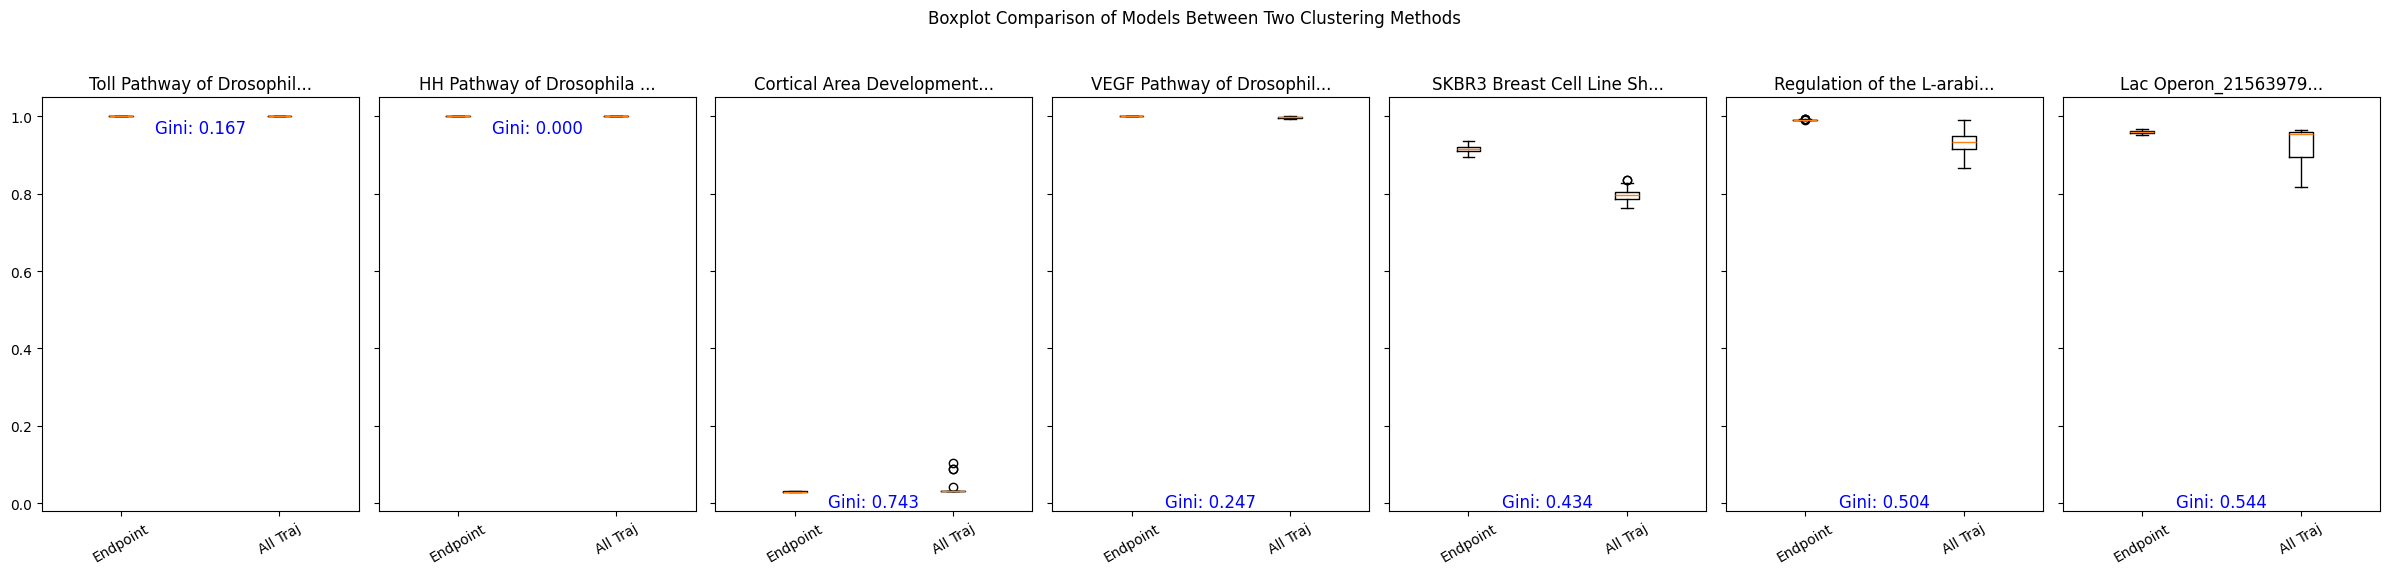

In [10]:
import matplotlib.pyplot as plt

# Prepare data for boxplot
fig, axes = plt.subplots(1, 7, figsize=(24, 6), sharey=True)
model_names = endpoint.columns

for i, model in enumerate(model_names):
    data = [
        combined_df[('Endpoint Clustering', model)],
        combined_df[('All Trajectories Clustering', model)]
    ]
    axes[i].boxplot(data, labels=['Endpoint', 'All Traj'])
    axes[i].set_title(model[:25] + '...')  # Shorten title for readability
    axes[i].set_xticklabels(['Endpoint', 'All Traj'], rotation=30)
    
    # Get gini_score for this model
    gini = model_attributes.loc[model_attributes['project_name'] == model, 'gini_score'].values
    if len(gini) > 0:
        ymin = axes[i].get_ylim()[0]
        axes[i].text(1.5, ymin, f"Gini: {gini[0]:.3f}", 
                     ha='center', va='bottom', fontsize=12, color='blue')

fig.suptitle('Boxplot Comparison of Models Between Two Clustering Methods')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()